In [1]:
import altair as alt
import pandas as pd
import numpy as np
from toolz.curried import pipe
import os
from pygbif import species
import geopandas as gpd
import json

import sys
sys.path.append("../../code")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer
from IPython.display import Image

# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

In [2]:
tree = pd.read_csv("../../data/processed/public_trees_cleaned.csv", delimiter=",")

small_tree_ranges = ['10-20']
medium_tree_ranges = ['20-30', '30-40']
large_tree_ranges = ['40-50', '50-60', '60-70', '70-80', '80-90', '>90']

size_mapping = {
    'Small': ['10-20'],
    'Medium': ['20-30', '30-40'],
    'Large': ['40-50', '50-60', '60-70', '70-80', '80-90', '>90']
}

# Reverse mapping: height_range -> size_category
height_range_to_size = {
    **{r: 'Small' for r in size_mapping['Small']},
    **{r: 'Medium' for r in size_mapping['Medium']},
    **{r: 'Large' for r in size_mapping['Large']}
}

tree['HEIGHT_SIZE'] = (
    tree['HEIGHT_RANGE']
    .map(height_range_to_size)
    .astype(pd.CategoricalDtype(
        categories=['Small', 'Medium', 'Large'], 
        ordered=True
    )))

tree.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN,HEIGHT_SIZE
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True,Medium
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False,Medium
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True,Small
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False,Small
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False,Small


### Question 1: How do height and diameter vary across different tree species in Vancouver’s public spaces?

**Task Analysis**:
1. Characterize Distribution: Analyze the distribution of diameters and heights among different tree species.
2. Filter: Filter data to only include trees from the top 20 families 
3. Compute Derived Value:  Compute the average diameter and tree count for each species-height combination.
4. Find Extremum: Identify which tree species has the largest or smallest average diameter
5. Determine Range: Identity the range of tree diameters within each tree species and height category
6. Find Anomalies: Identify if any species has unexpectedly high or low diameters at specific heights
7. Sort: Rank tree species by average diameter in ascending order


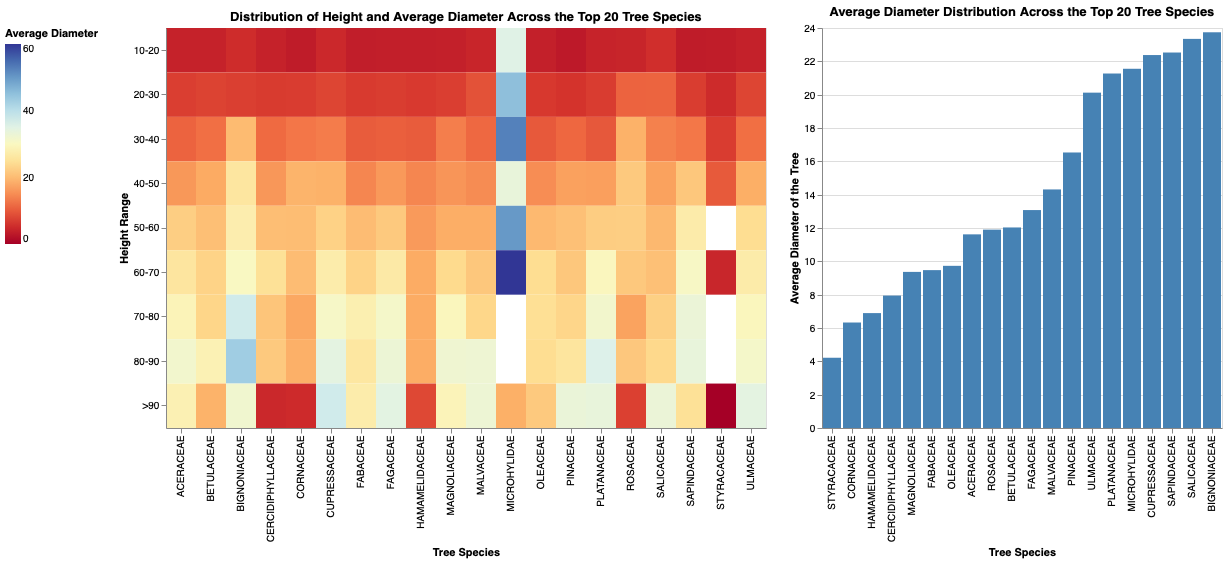

In [3]:
top_20_species = tree['FAMILY_NAME'].value_counts().head(20).index.tolist()

# Filter data for top 20 family species
top_20_tree_species  = tree[tree['FAMILY_NAME'].isin(top_20_species)]

tree_data = top_20_tree_species.groupby(['FAMILY_NAME', 'HEIGHT_RANGE']).agg(
    avg_diameter=('DIAMETER', 'mean'),
    tree_count=('HEIGHT_RANGE', 'size')  # Count all entries in group
).reset_index().dropna()

# Shared Selection for Tree Species (Click)
species_selection = alt.selection_point(fields=['FAMILY_NAME'], name="species_select")

# Hover Effect (Highlight on Hover)
hover_selection = alt.selection_point(fields=['FAMILY_NAME'], name="hover_select", empty="none")

# Heatmap Chart
heatmap = alt.Chart(tree_data).mark_rect().encode(
    alt.X('FAMILY_NAME:N', title='Tree Species'),
    alt.Y('HEIGHT_RANGE:N', title='Height Range'),
    alt.Color('avg_diameter:Q', title='Average Diameter', scale=alt.Scale(scheme='redyellowblue'), legend = alt.Legend(orient="left")),
    opacity=alt.condition(species_selection | hover_selection, alt.value(1), alt.value(0.3)),
    tooltip=[
        alt.Tooltip('FAMILY_NAME:N', title='Species'),
        alt.Tooltip('HEIGHT_RANGE:N', title='Height Range'),
        alt.Tooltip('avg_diameter:Q', title='Avg Diameter', format='.1f'),
        alt.Tooltip('tree_count:Q', title='Tree Count')
    ]
).add_params(species_selection, hover_selection).properties(
    title='Distribution of Height and Average Diameter Across the Top 20 Tree Species',
    width=600,
    height=400
)

avgdia_tree_dist = alt.Chart(top_20_tree_species).mark_bar().encode(
    alt.X("FAMILY_NAME:N", title="Tree Species", sort="y"),
    alt.Y("average(DIAMETER):Q", title="Average Diameter of the Tree", aggregate="mean"),
    opacity=alt.condition(species_selection | hover_selection, alt.value(1), alt.value(0.3)),
    color=alt.condition(hover_selection, alt.value("orange"), alt.value("steelblue")),
    tooltip=['FAMILY_NAME:N', alt.Tooltip('average(DIAMETER):Q', title='Avg Diameter', format='.1f')]
).add_params(species_selection, hover_selection).properties(
    title="Average Diameter Distribution Across the Top 20 Tree Species",
    height=400,
    width=400
)

# Combine Charts
heatmap | avgdia_tree_dist

### Justification of Visualization Choices

**Mark**:
1. Heatmap: Used to compare tree diameters across different height ranges and species. The color intensity effectively illustrates variations in diameter at various heights, making patterns and outliers easily identifiable.
2. Bar Chart: Used to show the average tree diameter for the top 20 species.The height of each bar allows for straightforward comparisons of tree species regarding diameter, making it easy to rank them.


**Channels**:
1. Heatmap
- Position: The X-axis represents different tree species, while the Y-axis denotes height ranges. This layout facilitates easy comparisons across species at various heights.
- Color: The colors represent diameter size using a clear gradient for visualizing variations.

**Bar Chart**
- Position: The X-axis shows various tree species, while the Y-axis indicates their average diameter, promoting an intuitive understanding of size differences.
- Length: The height of the bars represents the average diameter for each species. The bars are sorted in ascending order, simplifying the identification of species with the largest or smallest diameters.

**Interaction and UI Widges**:

- Filtering: Allows users to select specific tree species for focused analysis
- Brushing & Linking:  Clicking on a species in the bar chart highlights the corresponding cells in the heatmap, allowing users to track diameter variations across height ranges.
- Hovering: Tooltips display exact numerical values for tree diameters, the species name, and the height category, enhancing interpretability.

### Question 2: How does the spatial distribution of the physical traits of species differ across Vancouver?

**Task Analysis**:
1. Characterize Distribution: Analyze the distribution of diameters and heights in latitudes
2. Filter: 
- Filter data to only include trees from the top 20 families 
- Filter trees based on the selected height category in the bar chart
3. Compute Derived Value:  Compute the average diameter and tree count for a given latitude and height category.
4. Find Extremum: Identify the latitude where the trees have the largest or smallest average diameter
5. Determine Range: Identity the range of tree diameters within each tree species and height category
6. Correlate: Analyze the relationship between latitude and tree size distribution.
7. Sort: Rank tree species by tree count for the selected height


/var/folders/_1/lgnyx9tx3p94x_9793cjt2s80000gn/T/ipykernel_43470/2691809505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_tree_species["latitude_bin"] = (top_20_tree_species["LATITUDE"] // 0.01  ) * 0.01


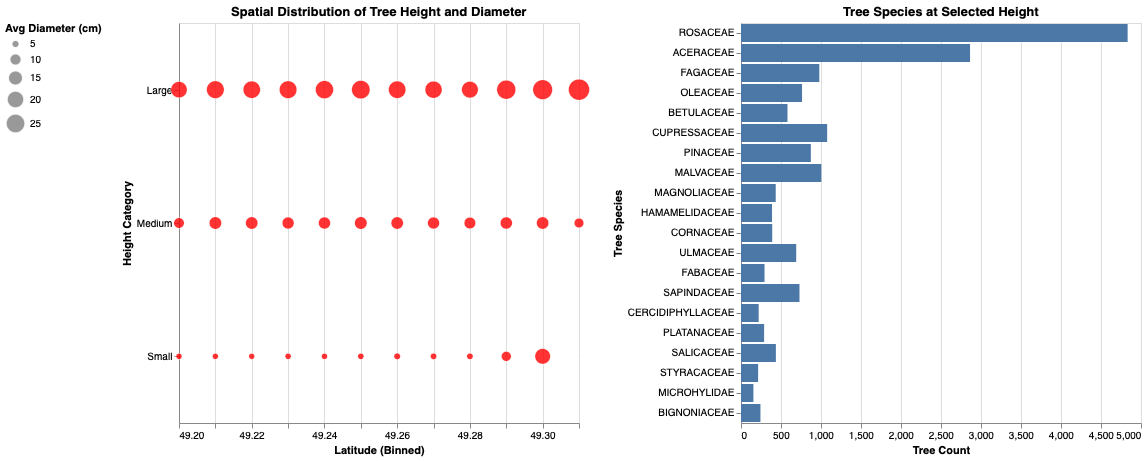

In [10]:
bin_step = 0.01  
top_20_tree_species["latitude_bin"] = (top_20_tree_species["LATITUDE"] // 0.01  ) * 0.01    

# Get unique latitude bins, sorted
latitude_bins = sorted(top_20_tree_species["latitude_bin"].unique())

# Add "All" to the options
latitude_options = ["All"] + [str(round(lat, 4)) for lat in latitude_bins]

# Create height radio button selection
height_radio = alt.binding_radio(
    options=["Show All", "Small", "Medium", "Large"], name="Height: "
)

height_selection = alt.selection_point(
    fields=['HEIGHT_SIZE'],
    bind=height_radio,
    empty="all"  # Ensures default selection shows all data
)

# Create latitude radio button selection
latitude_radio = alt.selection_point(
    fields=["latitude_bin"],
    bind=alt.binding_radio(
        options=latitude_options,
        name="Select Latitude Bin: "
    ),
    name="LatitudeSelection"
)

# Scatter Plot
scatter = alt.Chart(top_20_tree_species).transform_aggregate(
    avg_diameter='mean(DIAMETER)',
    count='count()',
    groupby=['HEIGHT_SIZE', 'latitude_bin']
).transform_calculate(
    jitter="sqrt(-2*log(random()))*cos(2*PI*random()) * 0.2"
).mark_circle(
    opacity=0.8,
    stroke='white',
    strokeWidth=0.5
).encode(
    x=alt.X('latitude_bin:Q', title='Latitude (Binned)', scale=alt.Scale(domain=[49.2, 49.31])),
    y=alt.Y('HEIGHT_SIZE:N', title='Height Category', axis=alt.Axis(labelAngle=0)),
    size=alt.Size('avg_diameter:Q', title='Avg Diameter (cm)', scale=alt.Scale(domain=[2, 25]), legend=alt.Legend(orient="left")),
    color=alt.condition(height_selection & latitude_radio, alt.value("red"), alt.value("gray")),
    tooltip=[
        alt.Tooltip('latitude_bin:Q', title='Latitude', format='.4f'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Category'),
        alt.Tooltip('avg_diameter:Q', title='Avg Diameter (cm)', format='.1f'),
        alt.Tooltip('count:Q', title='Tree Count')
    ]
).add_params(
    height_selection,
    latitude_radio
).properties(
    title="Spatial Distribution of Tree Height and Diameter",
    width=400,
    height=400
)

# Bar Chart (Tree Species)
species_chart = alt.Chart(top_20_tree_species).mark_bar().encode(
    x=alt.X('count():Q', title="Tree Count"),
    y=alt.Y('FAMILY_NAME:N', title="Tree Species", sort='-x'),
    tooltip=[
        alt.Tooltip('FAMILY_NAME:N', title="Tree Species"),
        alt.Tooltip('HEIGHT_SIZE:N', title="Height Category"),
        alt.Tooltip('mean(DIAMETER):Q', title="Avg Diameter (cm)", format='.1f'),
        alt.Tooltip('count():Q', title="Tree Count"),
        alt.Tooltip('latitude_bin:Q', title='Latitude', format='.4f')
    ]).add_params(
    height_selection,
    latitude_radio
).transform_filter(
    height_selection 
).transform_filter(
    latitude_radio 
).properties(
    title="Tree Species at Selected Height",
    width=400,
    height=400
)


# Combine scatter plot and bar chart
linked_view = scatter | species_chart
linked_view

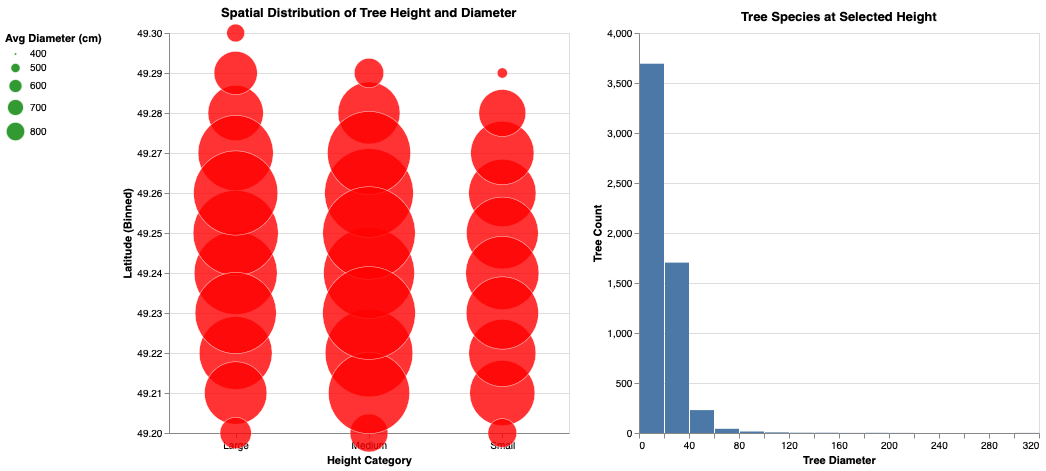

In [27]:
species_selection = alt.selection_point(
    fields=['FAMILY_NAME'],
    bind=alt.binding_select(
        options=list(top_20_tree_species['FAMILY_NAME'].unique()), 
        name="Select Tree Species:"
    ),
    name="Tree Species Selection"
)

dot_selection = alt.selection_point(
    fields=['HEIGHT_SIZE', 'latitude_bin'],
    on='click',
    name="Selected Dot"
)

# Scatter Plot (Latitude vs. Height Category)
scatter = alt.Chart(top_20_tree_species).transform_bin(
    'latitude_bin', 'LATITUDE', bin=alt.Bin(step=0.01)
).transform_aggregate(
    avg_diameter='mean(DIAMETER)',
    count='count()',
    groupby=['HEIGHT_SIZE', 'latitude_bin']
).transform_calculate(
    jitter="sqrt(-2*log(random()))*cos(2*PI*random()) * 0.2"
).mark_circle(
    opacity=0.8,
    stroke='white',
    strokeWidth=0.5
).encode(
    y=alt.Y('latitude_bin:Q', title='Latitude (Binned)', scale=alt.Scale(domain=[49.2, 49.3])),
    x=alt.X('HEIGHT_SIZE:N', title='Height Category', axis=alt.Axis(labelAngle=0)),
    size=alt.Size('count:Q', title='Avg Diameter (cm)', scale=alt.Scale(domain=[400,800]), legend = alt.Legend(orient="left")),
    color=alt.condition(dot_selection, alt.value("red"), alt.value("green")),  # Highlight selected category
    tooltip=[
        alt.Tooltip('latitude_bin:Q', title='Latitude', format='.4f'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Category'),
        alt.Tooltip('avg_diameter:Q', title='Avg Diameter (cm)', format='.1f'),
        alt.Tooltip('count:Q', title='Tree Count')
    ]
).add_params(
    dot_selection
).properties(
    title="Spatial Distribution of Tree Height and Diameter",
    width=400,
    height=400
)


species_chart = alt.Chart(top_20_tree_species).mark_bar().transform_bin(
    'latitude_bin', 'LATITUDE', bin=alt.Bin(step=0.01)
).encode(
    x=alt.X('DIAMETER:Q', bin=alt.Bin(maxbins=30), title="Tree Diameter"),
    y=alt.Y('count()', title="Tree Count"),
    tooltip=[
        alt.Tooltip('FAMILY_NAME:N', title="Tree Species"),
        alt.Tooltip('HEIGHT_SIZE:N', title="Height Category"),
        alt.Tooltip('mean(DIAMETER):Q', title="Avg Diameter (cm)", format='.1f'),
        alt.Tooltip('count():Q', title="Tree Count"),
        alt.Tooltip('latitude_bin:Q', title='Latitude', format='.4f')
    ]).transform_filter(dot_selection
).properties(
    title="Tree Species at Selected Height",
    width=400,
    height=400
)

linked_view = scatter | species_chart
linked_view

### Justification of Visualization Choices

**Marks**:
1. Scatter Plots: Used to represent tree diameters at different latitudes for various height categories. Each point represents an aggregated average, making spatial trends clear.
2. Bar Charts: Used to display the dominant species within each height category. This allows for easy comparison of species distribution across different tree sizes.

**Channels**:
- Position (Latitude vs. Height Category in Scatter Plots): Latitude is mapped to the x-axis, and Height Category is mapped to the y-axis, enabling a clear spatial pattern analysis.
- Length (Bar Charts for Species Distribution): The height of each bar represents the relative abundance of tree species, making dominant species visually prominent.
- Size (Latitude vs. Height Category in Scatter Plots): The size of each point indicates the average tree diameter at various latitudes and height categories, making comparisons straightforward. 

**Interaction and UI Widges**
- Filtering by Height Category: The figures separate data by height (small, medium, large) using a drop-down menu, making it easier to interpret trends without information overload.
- Linked Views: The scatter plots and bar charts complement each other by showing both tree size variations and species composition, facilitating multi-faceted analysis.
- Highlighting Trends: The scatter plots reveal consistent spatial patterns, such as larger tree diameters in northern latitudes, while bar charts highlight species dominance.




### Question 3: How do height and diameter of tree influence their placement in different urban settings (e.g., streets, parks, medians, and greenways)?

**Task Analysis**:
1. Characterize Distribution: Analyze the distribution of diameters and heights among different street sides.
2. Filter: Filter data to only include trees from the top 20 families and limit tree diameter to below 60 cm
3. Compute Derived Value: Compute the total count of trees per street side and height category.
4. Find Extremum: Identify which street side has the largest or smallest proportion of each height category
5. Determine Range: Identity the range of tree diameters within each street side and height category
6. Find Anomalies: Identify if any street sides have an unusual height distribution.


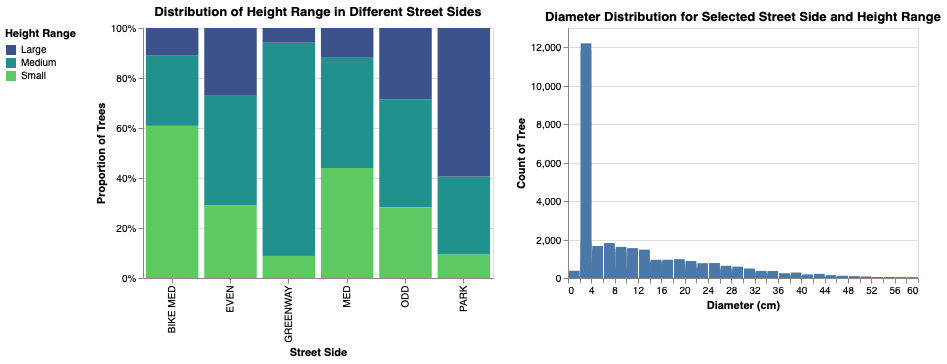

In [6]:
diameter_50 = top_20_tree_species[
    (top_20_tree_species["DIAMETER"] < 60) &
    (top_20_tree_species["DIAMETER"].notna())
]

height_radio = alt.binding_radio(
    options=["Show All", "Small", "Medium", "Large"], name="Height: "
)

height_selection = alt.selection_point(
    fields=['HEIGHT_SIZE'],
    bind=height_radio,
    empty=True  # Ensures a default selection
)

street_radio = alt.binding_radio(
    options=["Show All"] + list(diameter_50['STREET_SIDE_NAME'].unique()), name="Street Side: "
)

street_selection = alt.selection_point(
    fields=['STREET_SIDE_NAME'],
    bind=street_radio,
    empty=True  # Ensures a default selection
)

height_bar = alt.Chart(diameter_50).mark_bar().encode(
    alt.X("STREET_SIDE_NAME:N", title="Street Side"),
    alt.Y("count():Q", stack="normalize", title="Proportion of Trees"),
    alt.Color("HEIGHT_SIZE:N", 
          scale=alt.Scale(scheme="viridis"), 
          title="Height Range",
          legend=alt.Legend(orient="left")),
    opacity=alt.condition(
        height_selection & street_selection,  
        alt.value(1),  # Highlight selected
        alt.value(0.3)  # Dim others
    ),
    tooltip=[
        alt.Tooltip('STREET_SIDE_NAME:N', title='Street Side'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Size'),
        alt.Tooltip('count():Q', title='Count of Tree')
    ]
).add_params(height_selection, street_selection).properties(
    title="Distribution of Height Range in Different Street Sides",
    height=250,
    width=350
)

diameter_hist = alt.Chart(diameter_50).mark_bar().encode(
    alt.X("DIAMETER:Q", bin=alt.Bin(maxbins=30), title="Diameter (cm)"),
    alt.Y("count():Q", title="Count of Tree"),
    tooltip=[
        alt.Tooltip('STREET_SIDE_NAME:N', title='Street Side'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Size'),
        alt.Tooltip('count():Q', title='Count of Tree'),
        alt.Tooltip('DIAMETER:Q', title='Diameter')
    ]
).transform_filter(
    height_selection & street_selection   # Filters based on selection
).properties(
    title="Diameter Distribution for Selected Street Side and Height Range",
    height=250,
    width=350
)

(height_bar | diameter_hist)

### Justification of Visualization Choices

**Mark:**
1. Stacked Bar Chat: Used to compare tree height categories (small, medium, large) across different street sides. The stacked format allows for a direct proportional comparison across categories.
2. Histogram: Used to represent the frequency distribution of tree diameters for the selected street side and height category. The binning approach in the histogram effectively shows the distribution of tree sizes.

**Channels:**
1. Stacked Bar Chart
- Position: X-axis represents different street sides, allowing for direct comparisons of tree distribution across urban settings. Y-axis represents the proportion of trees in each height category, making it easy to compare different tree sizes.
- Color: Different tree height categories (small, medium, large) are represented by distinct colors, helping to distinguish between the height distributions.

2. Histogram
- Position (Histogram): X-axis represents tree diameter values, enabling users to see the distribution of tree trunk sizes. Y-axis represents tree counts, showing the frequency of different diameter ranges.

**Interaction and UI Widges:**
- Street Selection: Users can choose between even, odd, median, park, bike medians, and greenways.
- Height Selection: Users can filter tree heights to focus on small, medium, or large trees.
- Selecting a street type and height category updates the histogram and highlights the corresponding proportion in the stacked bar chart, allowing users to explore specific subsets of data and analyze relationships between height and diameter.
